In [1]:
import cv2
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
def Histogram(image, L=256):
    p = np.zeros(L)
    row, col = image.shape  
    for i in range(0,row):
        for j in range(0,col):
            p[image[i,j]] += 1

    return p/(row*col)

def find_optimal_threshold(image):
    p = Histogram(image)
    variance = np.zeros(256)

    for t in range(0, 256):
        w0 = sum(p[0:t+1])
        u0 = (sum(i * p[i] for i in range(0, t+1)) / w0) if w0 > 0 else 0
        w1 = 1 - w0
        u1 = (sum(i * p[i] for i in range(t+1, 256)) / w1) if w1 > 0 else 0
        u = u0 * w0 + u1 * w1
        variance[t] = w0 * (u0 - u)**2 + w1 * (u1 - u)**2

    return np.argmax(variance)


In [3]:
def remove_green_background(image):

    r, g, b = cv2.split(image)

    # Create a binary mask for green pixels
    mask = (g > r) & (g > b)

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image[mask] = 0
    gray_image[~mask] = 255

    result = cv2.bitwise_and(image, image, mask=gray_image)
    
    return result

def extract_v_component(image):

    # Convert RGB image to YUV color space
    yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    _, _, v = cv2.split(yuv_image)
    return v

def remove_non_green_background(v_component):

    # Apply Otsu segmentation on V component
    threshold = find_optimal_threshold(v_component)
    _, binary_image = cv2.threshold(v_component, threshold, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Apply area threshold to remove small noise
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 100:
            cv2.drawContours(binary_image, [contour], 0, 0, thickness=cv2.FILLED)

    return binary_image

def extract_diseased_spot_rgb(original_image, binary_image):
    
    r, g, b = cv2.split(original_image)

    # Apply "AND" operation to extract diseased spot RGB image
    r_, g_, b_ = cv2.bitwise_and(r, r, mask=binary_image), cv2.bitwise_and(g, g, mask=binary_image), cv2.bitwise_and(b, b, mask=binary_image)
    diseased_spot_rgb = cv2.merge([r_, g_, b_])

    return diseased_spot_rgb

Text(0.5, 1.0, 'Original Image')

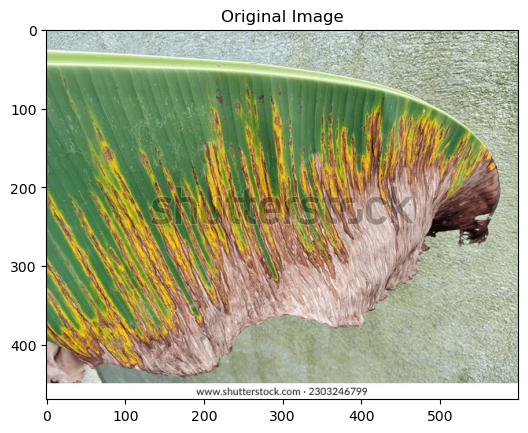

In [4]:
# Load the image (Use your own image path here)
image = cv2.imread("datasets/collection/img9.png")  
truth_image = cv2.imread("datasets/collection_truth/img9.png")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
truth_image = cv2.cvtColor(truth_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(image)
plt.title('Original Image')


Text(0.5, 1.0, 'Image Without Green Background')

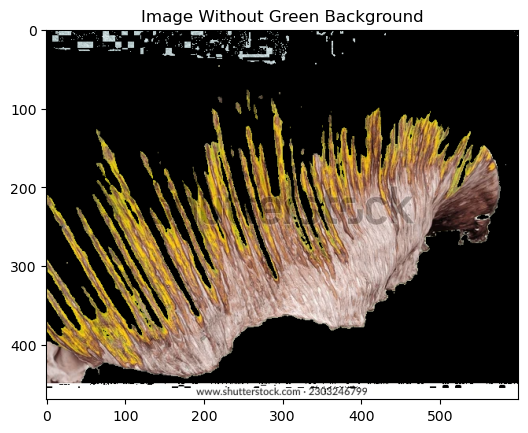

In [5]:
# Step 1: Remove Green Background
image_without_green = remove_green_background(image)
plt.imshow(image_without_green)
plt.title('Image Without Green Background')

Text(0.5, 1.0, 'V Component')

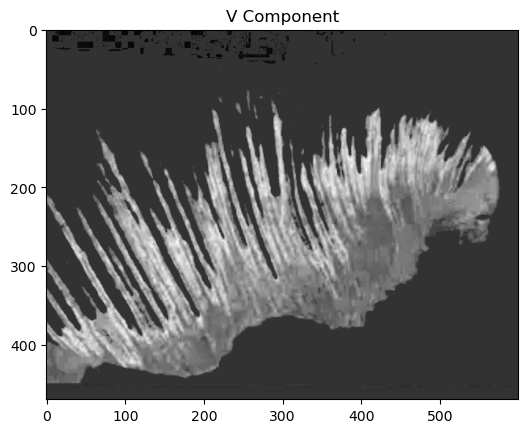

In [6]:
# Step 2: Convert to YUV Color Space
v_component = extract_v_component(image_without_green)
plt.imshow(v_component, cmap='gray')
plt.title('V Component')

Text(0.5, 1.0, 'Binary Image')

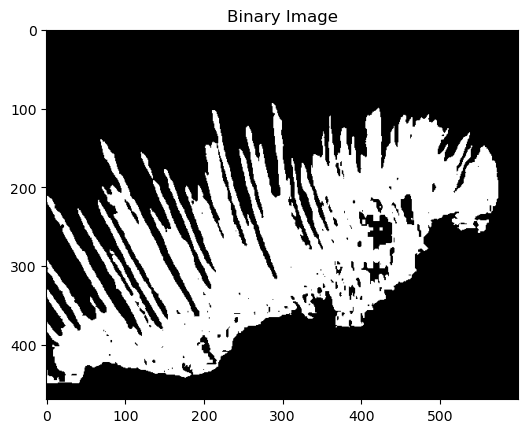

In [7]:
# Step 3: Remove Non-Green Background
binary_image = remove_non_green_background(v_component)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')

Text(0.5, 1.0, 'Diseased Spot RGB Image')

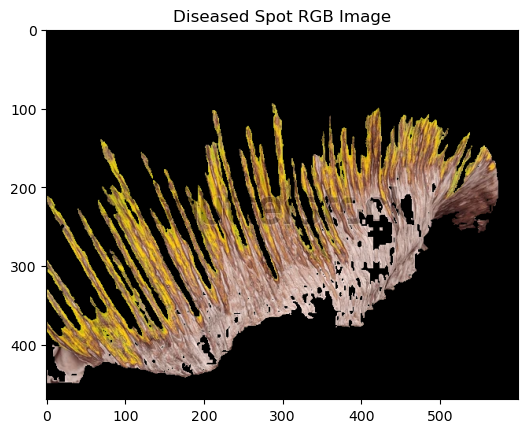

In [8]:
# Step 4: Extract Diseased Spot RGB Image
diseased_spot_rgb = extract_diseased_spot_rgb(image, binary_image)
plt.imshow(diseased_spot_rgb)
plt.title('Diseased Spot RGB Image')

Text(0.5, 1.0, 'Truth Image')

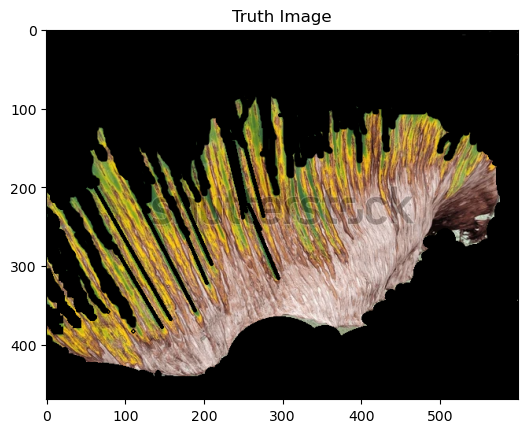

In [9]:
plt.imshow(truth_image)
plt.title('Truth Image')

In [10]:
acc = accuracy_score(truth_image.flatten(), diseased_spot_rgb.flatten())
print("Accuracy:", acc)

Accuracy: 0.8976832151300237


In [11]:
truth_image_ = truth_image.flatten()
truth_image_[truth_image_ == 0] = 0
truth_image_[truth_image_ != 0] = 1

diseased_spot_rgb_ = diseased_spot_rgb.flatten()
diseased_spot_rgb_[diseased_spot_rgb_ == 0] = 0
diseased_spot_rgb_[diseased_spot_rgb_ != 0] = 1

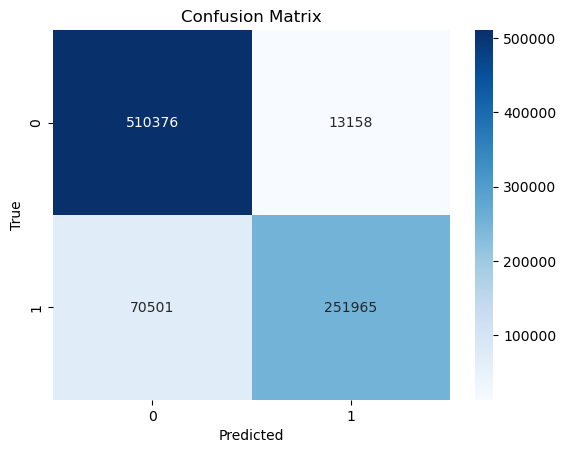

In [12]:
conf_matrix = confusion_matrix(y_true=truth_image_, y_pred=diseased_spot_rgb_)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()